<a href="https://colab.research.google.com/github/Pumafi/dl_spatial_gen_geol_facies/blob/main/trilemna_solving_diff_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Diffusion Implicit Models

**Author:** [András Béres](https://www.linkedin.com/in/andras-beres-789190210)<br>
**Date created:** 2022/06/24<br>
**Last modified:** 2022/06/24<br>
**Description:** Generating images of flowers with denoising diffusion implicit models.

## Introduction

### What are diffusion models?

Recently, [denoising diffusion models](https://arxiv.org/abs/2006.11239), including
[score-based generative models](https://arxiv.org/abs/1907.05600), gained popularity as a
powerful class of generative models, that can [rival](https://arxiv.org/abs/2105.05233)
even [generative adversarial networks (GANs)](https://arxiv.org/abs/1406.2661) in image
synthesis quality. They tend to generate more diverse samples, while being stable to
train and easy to scale. Recent large diffusion models, such as
[DALL-E 2](https://openai.com/dall-e-2/) and [Imagen](https://imagen.research.google/),
have shown incredible text-to-image generation capability. One of their drawbacks is
however, that they are slower to sample from, because they require multiple forward passes
for generating an image.

Diffusion refers to the process of turning a structured signal (an image) into noise
step-by-step. By simulating diffusion, we can generate noisy images from our training
images, and can train a neural network to try to denoise them. Using the trained network
we can simulate the opposite of diffusion, reverse diffusion, which is the process of an
image emerging from noise.

![diffusion process gif](https://i.imgur.com/dipPOfa.gif)

One-sentence summary: **diffusion models are trained to denoise noisy images, and can
generate images by iteratively denoising pure noise.**

### Goal of this example

This code example intends to be a minimal but feature-complete (with a generation quality
metric) implementation of diffusion models, with modest compute requirements and
reasonable performance. My implementation choices and hyperparameter tuning were done
with these goals in mind.

Since currently the literature of diffusion models is
[mathematically quite complex](https://arxiv.org/abs/2206.00364)
with multiple theoretical frameworks
([score matching](https://arxiv.org/abs/1907.05600),
[differential equations](https://arxiv.org/abs/2011.13456),
[Markov chains](https://arxiv.org/abs/2006.11239)) and sometimes even
[conflicting notations (see Appendix C.2)](https://arxiv.org/abs/2010.02502),
it can be daunting trying to understand
them. My view of these models in this example will be that they learn to separate a
noisy image into its image and Gaussian noise components.

In this example I made effort to break down all long mathematical expressions into
digestible pieces and gave all variables explanatory names. I also included numerous
links to relevant literature to help interested readers dive deeper into the topic, in
the hope that this code example will become a good starting point for practitioners
learning about diffusion models.

In the following sections, we will implement a continuous time version of
[Denoising Diffusion Implicit Models (DDIMs)](https://arxiv.org/abs/2010.02502)
with deterministic sampling.

## Setup

In [2]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from keras import layers

## Hyperparameters

In [3]:
# data
dataset_name = "oxford_flowers102"
dataset_repetitions = 5
num_epochs = 1  # train for at least 50 epochs for good results
image_size = 64
# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

## Data pipeline

We will use the
[Oxford Flowers 102](https://www.tensorflow.org/datasets/catalog/oxford_flowers102)
dataset for
generating images of flowers, which is a diverse natural dataset containing around 8,000
images. Unfortunately the official splits are imbalanced, as most of the images are
contained in the test split. We create new splits (80% train, 20% validation) using the
[Tensorflow Datasets slicing API](https://www.tensorflow.org/datasets/splits). We apply
center crops as preprocessing, and repeat the dataset multiple times (reason given in the
next section).

In [4]:

def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


# load dataset
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteYJ0A00/oxford_flowers102-train.tfrecord*…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteYJ0A00/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteYJ0A00/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


## Kernel inception distance

[Kernel Inception Distance (KID)](https://arxiv.org/abs/1801.01401) is an image quality
metric which was proposed as a replacement for the popular
[Frechet Inception Distance (FID)](https://arxiv.org/abs/1706.08500).
I prefer KID to FID because it is simpler to
implement, can be estimated per-batch, and is computationally lighter. More details
[here](https://keras.io/examples/generative/gan_ada/#kernel-inception-distance).

In this example, the images are evaluated at the minimal possible resolution of the
Inception network (75x75 instead of 299x299), and the metric is only measured on the
validation set for computational efficiency. We also limit the number of sampling steps
at evaluation to 5 for the same reason.

Since the dataset is relatively small, we go over the train and validation splits
multiple times per epoch, because the KID estimation is noisy and compute-intensive, so
we want to evaluate only after many iterations, but for many iterations.

In [5]:

class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()


## Network architecture

Here we specify the architecture of the neural network that we will use for denoising. We
build a [U-Net](https://arxiv.org/abs/1505.04597) with identical input and output
dimensions. U-Net is a popular semantic segmentation architecture, whose main idea is
that it progressively downsamples and then upsamples its input image, and adds skip
connections between layers having the same resolution. These help with gradient flow and
avoid introducing a representation bottleneck, unlike usual
[autoencoders](https://www.deeplearningbook.org/contents/autoencoders.html). Based on
this, one can view
[diffusion models as denoising autoencoders](https://benanne.github.io/2022/01/31/diffusion.html)
without a bottleneck.

The network takes two inputs, the noisy images and the variances of their noise
components. The latter is required since denoising a signal requires different operations
at different levels of noise. We transform the noise variances using sinusoidal
embeddings, similarly to positional encodings used both in
[transformers](https://arxiv.org/abs/1706.03762) and
[NeRF](https://arxiv.org/abs/2003.08934). This helps the network to be
[highly sensitive](https://arxiv.org/abs/2006.10739) to the noise level, which is
crucial for good performance. We implement sinusoidal embeddings using a
[Lambda layer](https://keras.io/api/layers/core_layers/lambda/).

Some other considerations:

* We build the network using the
[Keras Functional API](https://keras.io/guides/functional_api/), and use
[closures](https://twitter.com/fchollet/status/1441927912836321280) to build blocks of
layers in a consistent style.
* [Diffusion models](https://arxiv.org/abs/2006.11239) embed the index of the timestep of
the diffusion process instead of the noise variance, while
[score-based models (Table 1)](https://arxiv.org/abs/2206.00364)
usually use some function of the noise level. I
prefer the latter so that we can change the sampling schedule at inference time, without
retraining the network.
* [Diffusion models](https://arxiv.org/abs/2006.11239) input the embedding to each
convolution block separately. We only input it at the start of the network for
simplicity, which in my experience barely decreases performance, because the skip and
residual connections help the information propagate through the network properly.
* In the literature it is common to use
[attention layers](https://keras.io/api/layers/attention_layers/multi_head_attention/)
at lower resolutions for better global coherence. I omitted it for simplicity.
* We disable the learnable center and scale parameters of the batch normalization layers,
since the following convolution layers make them redundant.
* We initialize the last convolution's kernel to all zeros as a good practice, making the
network predict only zeros after initialization, which is the mean of its targets. This
will improve behaviour at the start of training and make the mean squared error loss
start at exactly 1.

In [6]:

def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

def TimestepEmbedding(hidden_dim, output_dim):
    def apply(time):
        e = layers.Lambda(sinusoidal_embedding)(time)
        e = layers.Dense(hidden_dim, activation=layers.LeakyReLU(alpha=0.2))(e)
        e = layers.Dense(output_dim, activation=layers.LeakyReLU(alpha=0.2))(e)
        return e
    return apply



def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    noisy_images_xt = keras.Input(shape=(image_size, image_size, 3))
    noise_input = keras.Input(shape=(image_size, image_size, 3))
    time = keras.Input(shape=(1, 1, 1))
    #end_time = keras.Input(shape=(1, 1, 1))

    e = TimestepEmbedding(128, 128)(time)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)
    #end_e = layers.Lambda(sinusoidal_embedding)(end_time)
    #end_e = layers.UpSampling2D(size=image_size, interpolation="nearest")(end_e)

    # e = layers.Concatenate(axis=-1)([start_e, end_e])

    embed_image = layers.Conv2D(widths[0], kernel_size=1)(noisy_images_xt)
    embed_noise = layers.Conv2D(widths[0], kernel_size=1)(noise_input)
    x = layers.Concatenate()([embed_image, embed_noise, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images_xt, noise_input, time], x, name="residual_unet")


In [7]:
import numpy as np

In [8]:
def conv_block(x, time, filters, activation, kernel_size=(3, 3), strides=(1, 1), padding="same", use_bn=False,
               use_dropout=False, drop_value=0.5, name="disc-conv-block-"):
    """
    Function to return a sequence of operations corresponding to a critic block of DCGAN;
    a convolution, a batchnorm, and an activation.
    Parameters:
        name:
        y: input slice
        filters: how many channels the output feature representation should have
        activation: the activation function ("sigmoid", "softmax"...)
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        strides: the stride of the convolution
        padding: "valid" for no padding, "same" to keep same size
        use_bn: bool, use BatchNormalization or not
        use_dropout: bool, use dropout or not
        drop_value: dropout value
    Returns:
        The output slice
    """
    y = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, name=name + "conv1"
    )(x)
    y = activation(y)

    e = layers.Dense(filters, activation=None)(time)
    e = layers.Reshape([1, 1, filters])(e)
    # e = layers.UpSampling2D(size=y.shape, interpolation="nearest")(e)
    # y = layers.Concatenate()([y, e])
    y = layers.Add()([y, e])

    y = layers.AveragePooling2D(pool_size=(2, 2), name=name + "-avg-pool1")(y)
    x = layers.AveragePooling2D(pool_size=(2, 2), name=name + "-avg-pool2")(x)

    y = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, name=name + "conv2"
    )(y)

    skip = layers.Conv2D(
        filters, (1, 1), strides=strides, padding="valid", name=name + "convskip"
    )(x)

    if use_bn:
        y = layers.BatchNormalization(name=name + "bn")(y)

    y = activation(y)

    y = layers.Add()([y, skip]) / np.sqrt(2)

    if use_dropout:
        y = layers.Dropout(drop_value, name=name + "dropout")(y)

    return y


def get_discriminator_network(image_size, widths, block_depth, time_emb_dim):
    noisy_images_xt = keras.Input(shape=(image_size, image_size, 3))
    noisy_images_xt_m1 = keras.Input(shape=(image_size, image_size, 3))
    #start_time = keras.Input(shape=(1, 1, 1))
    time = keras.Input(shape=(1, 1, 1))

    #start_e = layers.Lambda(sinusoidal_embedding)(start_time)
    #start_e = layers.UpSampling2D(size=image_size, interpolation="nearest")(start_e)
    #e = layers.Lambda(sinusoidal_embedding)(time)
    #e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)
    e = TimestepEmbedding(time_emb_dim, time_emb_dim)(time)

    #e = layers.Concatenate(axis=-1)([start_e, end_e])

    #embed_image_t = layers.Conv2D(widths[0], kernel_size=1)(noisy_images_xt)
    #embed_image_tm1 = layers.Conv2D(widths[0], kernel_size=1)(noisy_images_xt_m1)
    #x = layers.Concatenate()([embed_image_t, embed_image_tm1, e])
    x = layers.Concatenate()([noisy_images_xt, noisy_images_xt_m1])

    x = conv_block(x, e, 64, layers.LeakyReLU(alpha=0.2), name="disc-conv-block-1-")
    x = conv_block(x, e, 128, layers.LeakyReLU(alpha=0.2), name="disc-conv-block-2-")
    x = conv_block(x, e, 256, layers.LeakyReLU(alpha=0.2), name="disc-conv-block-3-")
    x = conv_block(x, e, 256, layers.LeakyReLU(alpha=0.2), name="disc-conv-block-4-")

    x = layers.Conv2D(256, kernel_size=1, kernel_initializer="zeros")(x)
    #x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same")(x)
    #x = layers.LeakyReLU(alpha=0.2)(x)
    #x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same")(x)
    #x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dense(1)(x)

    return keras.Model([noisy_images_xt, noisy_images_xt_m1, time], x, name="residual_disc")


This showcases the power of the Functional API. Note how we built a relatively complex
U-Net with skip connections, residual blocks, multiple inputs, and sinusoidal embeddings
in 80 lines of code!

In [12]:

class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

        self.discriminator = get_discriminator_network(image_size, widths, block_depth, time_emb_dim=128)
        self.discriminator_optimizer = keras.optimizers.Adam(learning_rate=3e-4)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_input, noise_rate, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_images = network([noisy_images, noise_input, noise_rate**2], training=training)

        return pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            generation_noises = tf.random.normal(shape=(num_images, image_size, image_size, 3))
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_images = self.denoise(
                noisy_images, generation_noises, noise_rates, training=False
            )
            pred_noises = (noisy_images - signal_rates * pred_images) / noise_rates
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)

        for i in range(2):
            #####################################################
            #####                DISCRIMINATOR             ######
            #####################################################
            noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))
            generation_noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))



            # sample uniform random diffusion times
            #step_sizes_t = tf.random.uniform(
            #    shape=(batch_size, 1, 1, 1), minval=0., maxval=1.
            #    )
            diffusion_times_t = tf.cast(tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=1, maxval=5, dtype=tf.int32) / 4, dtype=tf.float32)  #tf.clip_by_value(diffusion_times_tm1 + step_sizes_t, 0., 1.)
            noise_rates_t, signal_rates_t = self.diffusion_schedule(diffusion_times_t)
            # mix the images with noises accordingly
            noisy_images_t = signal_rates_t * images + noise_rates_t * noises

            # sample uniform random diffusion times
            diffusion_times_tm1 = diffusion_times_t - 0.25 #tf.random.uniform(
                #shape=(batch_size, 1, 1, 1), minval=0., maxval=1.
                #)
            noise_rates_tm1, signal_rates_tm1 = self.diffusion_schedule(diffusion_times_tm1)
            # mix the imm1ages with noises accordingly
            noisy_images_xtm1 = signal_rates_tm1 * images + noise_rates_tm1 * noises

            labels = tf.concat(
                [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
            )

            with tf.GradientTape() as tape:
                # train the network to separate noisy images to their components
                pred_x0 = self.denoise(
                    noisy_images_t, generation_noises, noise_rates_t, training=True
                    )
                pred_noisy_tm1 = signal_rates_tm1 * pred_x0 + noise_rates_tm1 * noises
                combined_images_tm1 = tf.concat([noisy_images_xtm1, pred_noisy_tm1], axis=0)
                combined_images_t = tf.concat([noisy_images_t, noisy_images_t], axis=0)
                combined_start_times = tf.concat([noise_rates_t, noise_rates_t], axis=0)

                predictions = self.discriminator([combined_images_t, combined_images_tm1, combined_start_times])
                d_loss = self.loss_fn(labels, predictions)

            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.discriminator_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
            noise_loss = d_loss #self.loss(noises, pred_noises)  # used for training

        #####################################################
        #######                GENERATOR             ########
        #####################################################
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))
        generation_noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        diffusion_times_t = tf.cast(tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=1, maxval=5, dtype=tf.int32) / 4, dtype=tf.float32)  #tf.clip_by_value(diffusion_times_tm1 + step_sizes_t, 0., 1.)
        noise_rates_t, signal_rates_t = self.diffusion_schedule(diffusion_times_t)
        # mix the images with noises accordingly
        noisy_images_t = signal_rates_t * images + noise_rates_t * noises

        # sample uniform random diffusion times
        diffusion_times_tm1 = diffusion_times_t - 0.25 #tf.random.uniform(
            #shape=(batch_size, 1, 1, 1), minval=0., maxval=1.
            #)
        noise_rates_tm1, signal_rates_tm1 = self.diffusion_schedule(diffusion_times_tm1)
        # mix the imm1ages with noises accordingly
        noisy_images_xtm1 = signal_rates_tm1 * images + noise_rates_tm1 * noises

        labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_x0 = self.denoise(
                noisy_images_t, generation_noises, noise_rates_t, training=True
                )
            pred_noisy_tm1 = signal_rates_tm1 * pred_x0 + noise_rates_tm1 * noises
            combined_images_tm1 = tf.concat([noisy_images_xtm1, pred_noisy_tm1], axis=0)
            combined_images_t = tf.concat([noisy_images_t, noisy_images_t], axis=0)
            combined_start_times = tf.concat([noise_rates_t, noise_rates_t], axis=0)

            predictions = self.discriminator([noisy_images_t, pred_noisy_tm1, diffusion_times_t])
            g_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(g_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(grads, self.network.trainable_weights)
        )
        image_loss = g_loss #self.loss(noises, pred_noises)  # used for training

        #gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        #self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

## Training

In [13]:
# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)
# below tensorflow 2.9:
# pip install tensorflow_addons
# import tensorflow_addons as tfa
# optimizer=tfa.optimizers.AdamW
model.compile(
    optimizer=keras.optimizers.experimental.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# pixelwise mean absolute error is used as loss

# save the best model based on the validation KID metric
checkpoint_path = "checkpoints/diffusion_model"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)
num_epochs=20
# run training and plot generated images periodically


In [14]:
model.fit(
    train_dataset,
    epochs=100,
)

Epoch 1/100
511/511 [==============================] - 299s 485ms/step - n_loss: 0.3150 - i_loss: 2.4090
Epoch 2/100
511/511 [==============================] - 251s 491ms/step - n_loss: 0.1292 - i_loss: 2.3229
Epoch 3/100
511/511 [==============================] - 251s 491ms/step - n_loss: 0.1437 - i_loss: 1.1418
Epoch 4/100
511/511 [==============================] - 251s 491ms/step - n_loss: 0.1338 - i_loss: 1.0788
Epoch 5/100
157/511 [========>.....................] - ETA: 2:53 - n_loss: 0.1358 - i_loss: 0.8438

KeyboardInterrupt: ignored

In [ ]:
noises1 = tf.random.normal(shape=(batch_size, image_size, image_size, 3))
noises2 = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

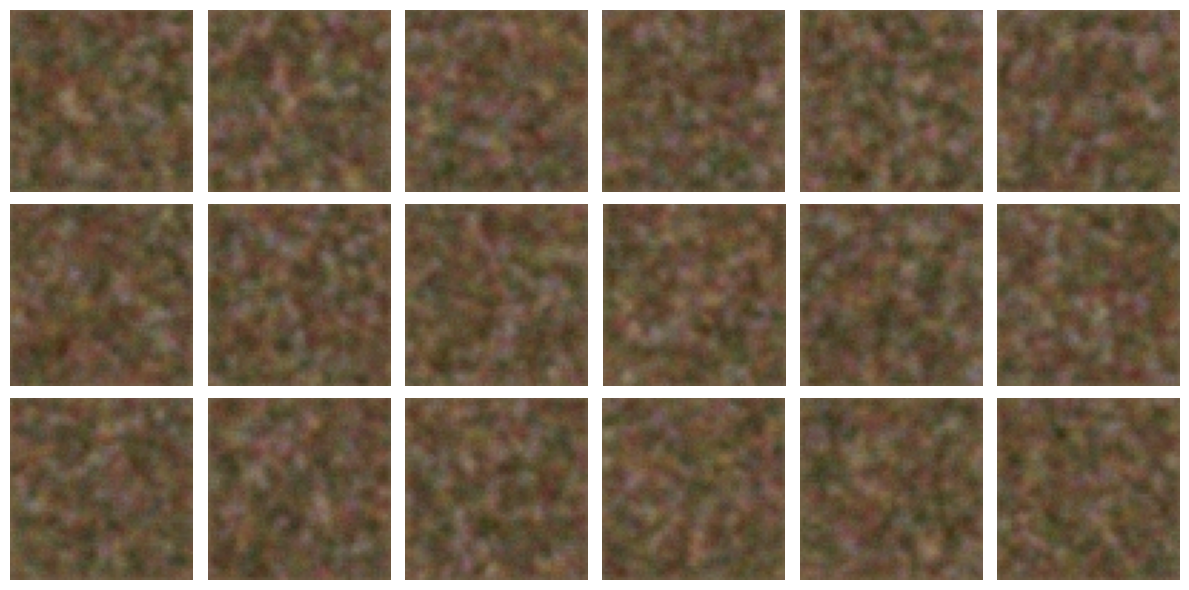

In [15]:
num_rows = 3
num_cols = 6
generated_images = model.generate(
    num_images=num_rows * num_cols,
    diffusion_steps=100,
)
plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
for row in range(num_rows):
    for col in range(num_cols):
        index = row * num_cols + col
        plt.subplot(num_rows, num_cols, index + 1)
        plt.imshow(generated_images[index])
        plt.axis("off")
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
num_rows = 3
num_cols = 6
generated_images = model.generate(
    num_images=num_rows * num_cols,
    diffusion_steps=100,
)
plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
for row in range(num_rows):
    for col in range(num_cols):
        index = row * num_cols + col
        plt.subplot(num_rows, num_cols, index + 1)
        plt.imshow(generated_images[index])
        plt.axis("off")
plt.tight_layout()
plt.show()
plt.close()

## Inference